# Reference graph from nested sequences

SPDX-License-Identifier: 0BSD

Treating all occurrences of elements that are non-sequences, or that are strings, as distinct leaves.

See `nested_tuples.ipynb` for a simpler version that handles only tuples.

In [1]:
from collections.abc import Sequence
import functools
import html
import itertools

from graphviz import Digraph
from typeguard import typechecked

In [2]:
@typechecked
def is_stringy(obj: object) -> bool:
    """Check if obj is string-like."""
    return isinstance(obj, bytearray | bytes | str)

In [3]:
@typechecked
def build_graph(root: object) -> Digraph:
    """Build a digraph of references starting in a nested collection."""
    vis = dict[int, object]()  # Stores visitation info and keeps objects alive.
    graph = Digraph()
    leaf_counter = itertools.count()
    
    @typechecked
    def add_edge(parent_name: str | None, current_name: str) -> None:
        if parent_name is not None:
            graph.edge(parent_name, current_name)
    
    @typechecked
    def dfs(parent_name: str | None, current_obj: object) -> None:
        if not isinstance(current_obj, Sequence) or is_stringy(current_obj):
            current_name = f'leaf-{next(leaf_counter)}'
            graph.node(current_name, label=html.escape(repr(current_obj)))
            add_edge(parent_name, current_name)
            return
        
        current_id = id(current_obj)
        current_name = str(current_id)
        seen_before = current_id in vis
        
        if not seen_before:
            vis[current_id] = current_obj
            graph.node(current_name, shape='point')
        
        add_edge(parent_name, current_name)
        
        if seen_before:
            return
        
        for child_obj in current_obj:
            dfs(current_name, child_obj)
    
    dfs(None, root)
    return graph

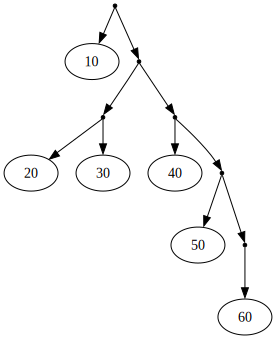

In [4]:
build_graph([10, ([20, 30], [40, (50, [60])])])

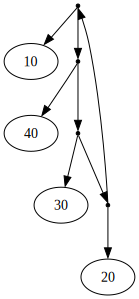

In [5]:
a = [10]
b = [20, a]
c = [30, b]
d = [40, c]
a.append(d)
build_graph(a)

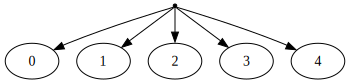

In [6]:
build_graph(range(5))

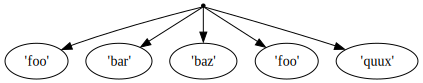

In [7]:
build_graph('foo bar baz foo quux'.split())

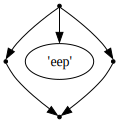

In [8]:
build_graph([[()], 'eep', [()]])

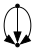

In [9]:
build_graph([(), (), ()])  # Not guaranteed to have 1 leaf.

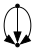

In [10]:
t = ()
build_graph([t, t, t])  # Guaranteed to have 1 leaf.

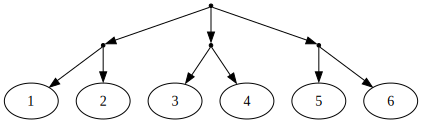

In [11]:
build_graph([[1, 2], [3, 4], [5, 6]])

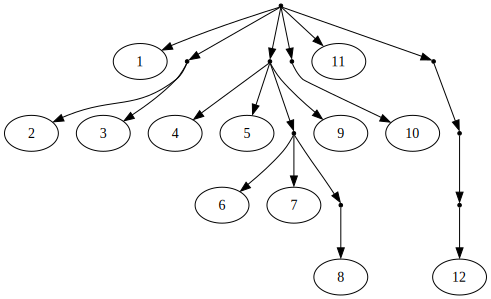

In [12]:
t = [1, [2, 3], (4, 5, [6, 7, [8]], 9), [10], 11, [[[12]]]]
build_graph(t)

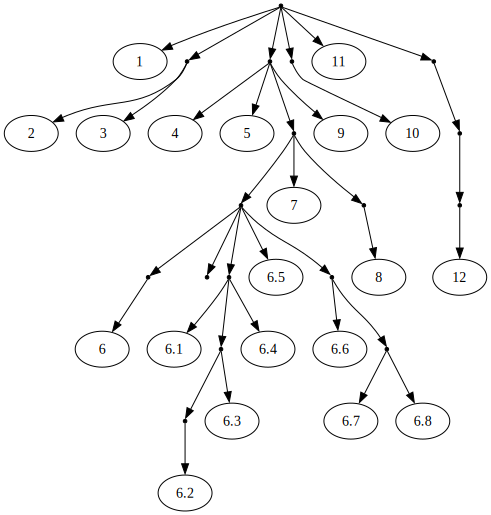

In [13]:
t = [1, [2, 3], (4, 5, [[[6], [], [6.1, [[6.2], 6.3], 6.4], 6.5, [6.6, [6.7, 6.8]]], 7, [8]], 9), [10], 11, [[[12]]]]
build_graph(t)

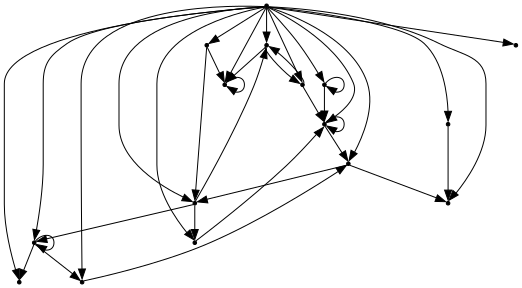

In [14]:
from random import randrange

n = 15
rows = [[] for _ in range(n)]
for _ in range(n * 3 // 2):
    rows[randrange(n)].append(rows[randrange(n)])

build_graph(rows)

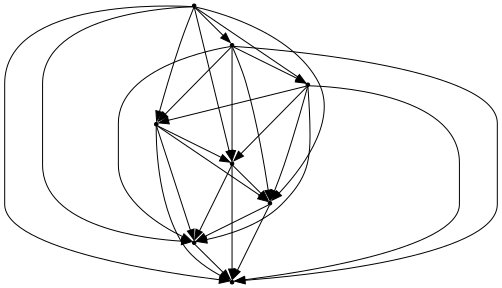

In [15]:
n = 8
rows = [[] for _ in range(n)]
for src, dest in itertools.combinations(rows, 2):
    src.append(dest)
build_graph(rows[0])

In [16]:
def make_binary_tree(height):
    if height == 0:
        return []
    return [make_binary_tree(height - 1), make_binary_tree(height - 1)]

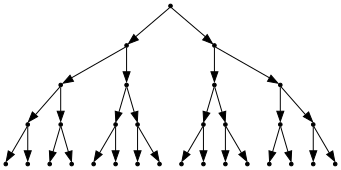

In [17]:
build_graph(make_binary_tree(4))

In [18]:
def make_fibonacci_tree(n):
    if n < 2:
        return []
    return [make_fibonacci_tree(n - 2), make_fibonacci_tree(n - 1)]

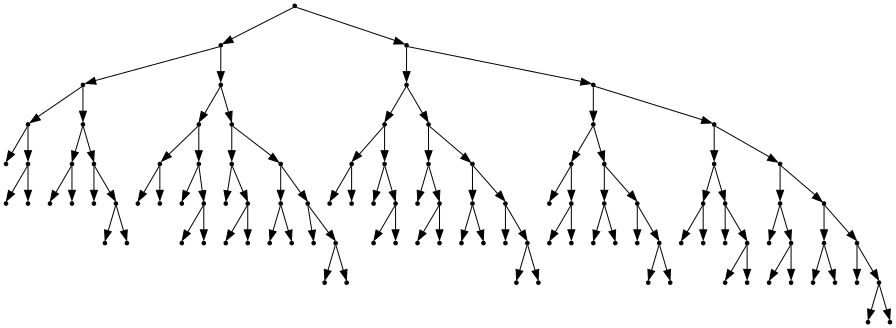

In [19]:
build_graph(make_fibonacci_tree(9))

In [20]:
@functools.cache
def make_fibonacci_tree_memoized(n):
    if n < 2:
        return []
    return [make_fibonacci_tree_memoized(n - 2), make_fibonacci_tree_memoized(n - 1)]

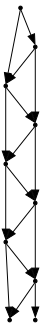

In [21]:
build_graph(make_fibonacci_tree_memoized(9))

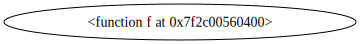

In [22]:
def f(x):
    return x

build_graph(f)

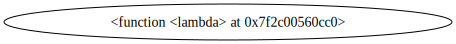

In [23]:
build_graph(lambda x: x)  # Test escaping.